In [60]:
# Python imports
import os
import math

# PyTorch imports
import torch
import torchvision

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# Own imports
import utils

# 0. Constants

In [61]:
BATCH_SIZE = 10
LEARNING_RATE = 0.001
EPOCHS = 30
WIDTH, HEIGHT = 28, 28
SAVED_FILENAME = 'MNIST-MLP-1'
LAYER_SIZE = 64

# 1. Dataset

In [62]:
# Load datasets.
dataset_training = torchvision.datasets.MNIST('./data', download=True, train=True, transform=torchvision.transforms.ToTensor())
dataset_test = torchvision.datasets.MNIST('./data', download=True, train=False, transform=torchvision.transforms.ToTensor())

# Create data loaders.
dataloader_training = torch.utils.data.DataLoader(dataset_training, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

# 2. Model

In [63]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(WIDTH*HEIGHT, LAYER_SIZE),
    torch.nn.BatchNorm1d(LAYER_SIZE),
    torch.nn.ReLU(),
    torch.nn.Linear(LAYER_SIZE, 10),
    torch.nn.Softmax(dim=1)
)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


## 2.1. Statistics of the Model

In [64]:
num_parameters_total = 0
for params in model.parameters():
    num_parameters = 1
    size = params.size()
    for dim_size in size:
        num_parameters *= dim_size
    num_parameters_total += num_parameters

print(f'Total number of parameters: {num_parameters_total}')

Total number of parameters: 51018


# 3. Training

## 3.1. Helper Functions

In [65]:
def calculateStatistics(dataloader, model, loss_fn):
    with torch.no_grad():
        num_batches = len(dataloader)
        num_samples = len(dataloader.dataset)
        loss, correct = 0, 0

        for images, labels in dataloader:
            # Make predictions.
            preds = model(images)

            # Calculate the loss.
            loss += loss_fn(preds, labels)

            # Calculate the number of correctnesses.
            correct += (preds.argmax(dim=1) == labels).type(dtype=torch.float32).sum()

        # Calculate the mean loss and correct.
        loss /= num_batches
        correct /= num_samples

    return loss, correct

## 3.2. Training

In [66]:
def getGrads(model):
    grads_weight = []
    grads_bias = []

    for layer in model:
        if type(layer) == torch.nn.Linear:
            grads_weight.append(layer.weight.grad.clone())
            grads_bias.append(layer.bias.grad.clone())

    return grads_weight, grads_bias

In [67]:
def load(model):
    # Retrieve saved data.
    data = torch.load(f'saved/{SAVED_FILENAME}.pt')

    # Resume model from saved data.
    state_dict = data['state_dict']
    model.load_state_dict(state_dict)

    # Return losses and accuracies for training and testing.
    return data['losses'], data['corrects'], data['losses_test'], data['corrects_test'], data['grads']

def save(model, losses, corrects, losses_test, corrects_test, grads):
    # Create folder 'saved' if it does not exist.
    if not os.path.exists('saved'):
        os.makedirs('saved')

    # Construct the struct of data to save.
    data = {
        'state_dict': model.state_dict(),
        'losses': losses,
        'corrects': corrects,
        'losses_test': losses_test,
        'corrects_test': corrects_test,
        'grads': grads,
    }

    # Save data to the file.
    torch.save(data, f'saved/{SAVED_FILENAME}.pt')

In [68]:
def train(model, epochs, learning_rate):
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), learning_rate)

    # Define losses and corrects for training and test.
    losses, corrects = [], []
    losses_test, corrects_test = [], []

    # Define the grad variables.
    grads = []

    # Calculate losses and corrects before training.
    loss, correct = calculateStatistics(dataloader_training, model, loss_fn)
    losses.append(loss)
    corrects.append(correct)
    loss_test, correct_test = calculateStatistics(dataloader_test, model, loss_fn)
    losses_test.append(loss)
    corrects_test.append(correct_test)

    # Print statistics.
    print(f'Training error: loss: {loss:>7f}, accuracy: {correct*100:>0.1f}%')
    print(f'Test error: loss: {loss_test:>7f}, accuracy: {correct_test*100:>0.1f}%')

    # Run epochs.
    for epoch in range(epochs):

        # Run one epoch for training.
        num_batches = len(dataloader_training)
        num_samples = len(dataloader_training.dataset)
        loss_epoch, correct_epoch = 0, 0
        grads_weight_epoch, grads_bias_epoch = None, None
        for batch, [images, labels] in enumerate(dataloader_training):
            # Make predictions.
            pred = model(images)

            # Calculate the loss.
            loss = loss_fn(pred, labels)
            loss_epoch += loss.item()

            # Calculate the number of correctness.
            correct_epoch += (pred.argmax(dim=1) == labels).type(dtype=torch.float32).sum().item()

            # Calculate gradients.
            optimizer.zero_grad()
            loss.backward()

            # Store the gradients.
            grads_weight_batch, grads_bias_batch = getGrads(model)
            if grads_weight_epoch == None:
                grads_weight_epoch = grads_weight_batch
            else:
                for i in range(len(grads_weight_epoch)):
                    grads_weight_epoch[i] += grads_weight_batch[i]
            if  grads_bias_epoch == None:
                grads_bias_epoch = grads_bias_batch
            else:
                for i in range(len(grads_bias_epoch)):
                    grads_bias_epoch[i] += grads_bias_batch[i]

            # Optimization.
            optimizer.step()

            if (batch + 1) % 1000 == 0:
                loss, size_current, size_total = loss.item(), (batch+1)*BATCH_SIZE, len(dataloader_training.dataset)
                print(f'loss: {loss:>7f} [{size_current:>5d} / {size_total:>5d}]')
            
        # Calculate the mean loss across all batches.
        loss_epoch /= num_batches
        losses.append(loss_epoch)

        # Calculate the mean number of correctness across all batches.
        correct_epoch /= num_samples
        corrects.append(correct_epoch)

        for i in range(len(grads_bias_epoch)):
            grads_weight_epoch[i] /= num_batches
        for i in range(len(grads_bias_epoch)):
            grads_bias_epoch[i] /= num_batches
        grads.append({
            'weight': grads_weight_epoch,
            'bias': grads_bias_epoch,
        })

        # Print statistics of the training part of the epoch.
        print(f'Training error: loss: {loss_epoch:>7f}, accuracy: {correct_epoch*100:>0.1f}%')

        # Calculate loss and correct for test.
        loss_test, correct_test = calculateStatistics(dataloader_test, model, loss_fn)
        losses_test.append(loss_test)
        corrects_test.append(correct_test)

        # Print statistics of the test part of the epoch.
        print(f'Test error: loss: {loss_test:>7f}, accuracy: {correct_test*100:>0.1f}%')

    # Return losses and accuracies for training and testing.
    return losses, corrects, losses_test, corrects_test, grads


In [69]:
if os.path.exists(f'saved/{SAVED_FILENAME}.pt'):
    losses, corrects, losses_test, corrects_test, grads = load(model)
else:
    losses, corrects, losses_test, corrects_test, grads = train(model, EPOCHS, LEARNING_RATE)
    save(model, losses, corrects, losses_test, corrects_test, grads)

Training error: loss: 2.303396, accuracy: 10.2%
Test error: loss: 2.303445, accuracy: 9.9%
loss: 2.254085 [10000 / 60000]
loss: 2.214051 [20000 / 60000]
loss: 2.030296 [30000 / 60000]
loss: 2.085974 [40000 / 60000]
loss: 2.107987 [50000 / 60000]
loss: 1.995024 [60000 / 60000]
Training error: loss: 2.111590, accuracy: 51.5%
Test error: loss: 1.967646, accuracy: 66.3%
loss: 2.047202 [10000 / 60000]
loss: 1.956641 [20000 / 60000]
loss: 1.920820 [30000 / 60000]
loss: 1.765759 [40000 / 60000]
loss: 1.782415 [50000 / 60000]
loss: 1.766381 [60000 / 60000]
Training error: loss: 1.892817, accuracy: 72.1%
Test error: loss: 1.823757, accuracy: 76.5%
loss: 1.936906 [10000 / 60000]
loss: 1.774658 [20000 / 60000]
loss: 1.833621 [30000 / 60000]
loss: 1.689996 [40000 / 60000]
loss: 1.874939 [50000 / 60000]
loss: 1.800164 [60000 / 60000]
Training error: loss: 1.790695, accuracy: 77.2%
Test error: loss: 1.759585, accuracy: 78.6%
loss: 1.782974 [10000 / 60000]
loss: 1.660870 [20000 / 60000]
loss: 1.66263

## 3.3. Visualization of the Training Process

### 3.3.1. Visualization of Losses and Accuracies

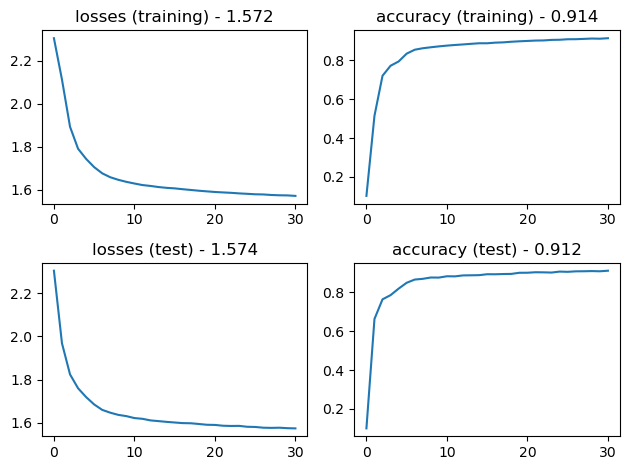

In [70]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2,2)

ax11.plot(losses)
ax11.set_title(f'losses (training) - {losses[EPOCHS]:.3f}')
ax12.plot(corrects)
ax12.set_title(f'accuracy (training) - {corrects[EPOCHS]:.3f}')
ax21.plot(losses_test)
ax21.set_title(f'losses (test) - {losses_test[EPOCHS]:.3f}')
ax22.plot(corrects_test)
ax22.set_title(f'accuracy (test) - {corrects_test[EPOCHS]:.3f}')

plt.tight_layout()
plt.show()

### 3.3.2. Visualization of Gradients

Calculate the mean and variance of the absolute values of gradients.

In [71]:
# Define how many rows to show in the table.
ROWS = 3 if len(grads) >= 3 else len(grads)

table = []
for row in range(ROWS):
    # Calculate which epoch to display.
    if row == ROWS - 1:
        index = EPOCHS - 1
    else:
        index = math.floor((EPOCHS / (ROWS - 1))) * row

    row_data = [
        f'Epoch #{index+1}',
        f'{grads[index]["weight"][0].abs().mean().item():.2e} ({grads[index]["weight"][0].abs().var().item():.2e})',
        f'{grads[index]["bias"][0].abs().mean().item():.2e} ({grads[index]["bias"][0].abs().var().item():.2e})',
        f'{grads[index]["weight"][1].abs().mean().item():.2e} ({grads[index]["weight"][1].abs().var().item():.2e})',
        f'{grads[index]["bias"][1].abs().mean().item():.2e} ({grads[index]["bias"][1].abs().var().item():.2e})',
    ]

    table.append(row_data)

print(tabulate(table, tablefmt='github', headers=['Epoch', 'Layer #1 - Weight', 'Layer #1 - Bias', 'Layer #2 - Weight', 'Layer #2 - Bias']))

| Epoch     | Layer #1 - Weight   | Layer #1 - Bias     | Layer #2 - Weight   | Layer #2 - Bias     |
|-----------|---------------------|---------------------|---------------------|---------------------|
| Epoch #1  | 4.09e-04 (3.54e-07) | 1.87e-11 (2.20e-22) | 3.63e-03 (9.99e-06) | 1.78e-03 (1.73e-06) |
| Epoch #16 | 5.94e-05 (5.90e-09) | 3.13e-11 (8.05e-22) | 5.62e-04 (1.11e-07) | 1.59e-04 (4.81e-08) |
| Epoch #30 | 5.70e-05 (5.78e-09) | 4.46e-11 (1.34e-21) | 3.74e-04 (4.87e-08) | 1.37e-04 (1.50e-08) |


Plot the distributions of gradients.

<Figure size 1000x700 with 0 Axes>

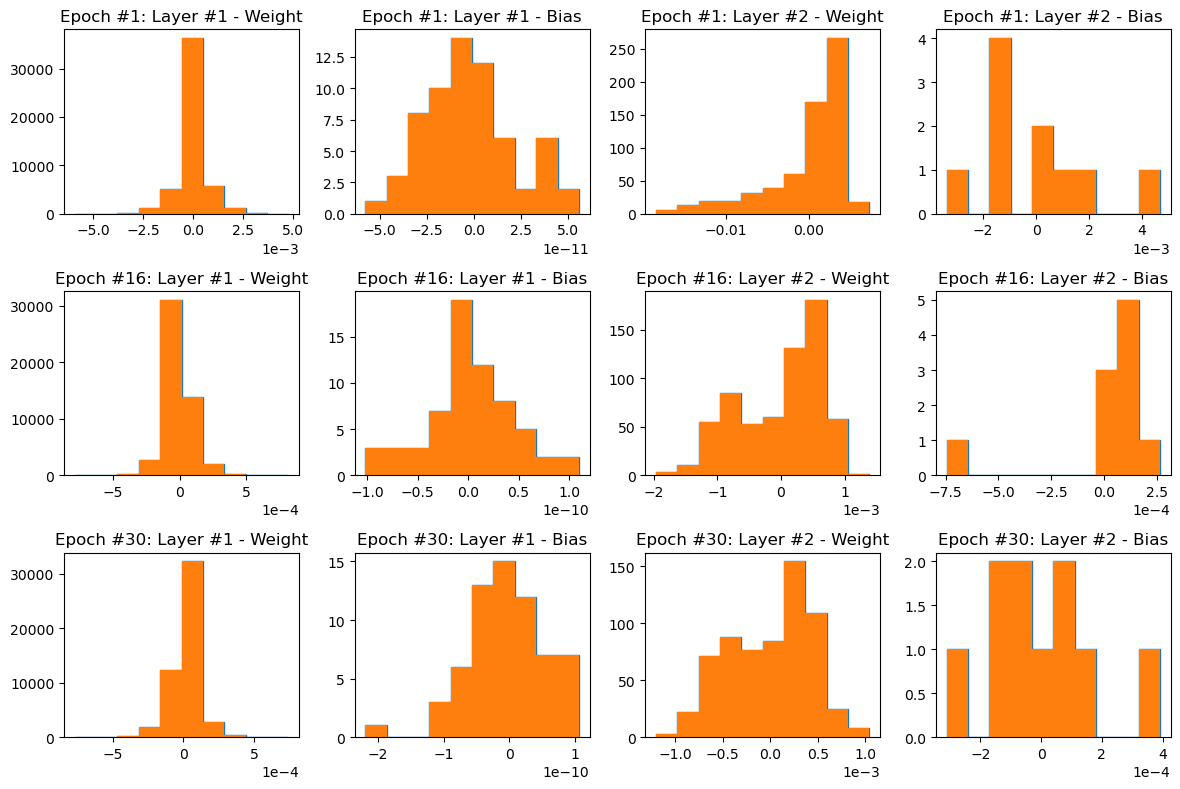

In [72]:
ROWS, COLS = 3 if len(grads) >= 3 else len(grads), 4

plt.figure(figsize=(10, 7))
fig, axs = plt.subplots(ROWS, COLS, figsize=(12, 8))
if ROWS == 1:
    axs = np.array([axs])
for row in range(ROWS):
    # Calculate which epoch to display.
    if row == ROWS - 1:
        index = EPOCHS - 1
    else:
        index = math.floor((EPOCHS / (ROWS - 1))) * row

    data = []
    data.append(grads[index]['weight'][0].numpy()) # Gradients of weight for level #1.
    data.append(grads[index]['bias'][0].numpy()) # Gradients of bias for level #1.
    data.append(grads[index]['weight'][1].numpy()) # Gradients of weight for level #2.
    data.append(grads[index]['bias'][1].numpy()) # Gradients of bias for level #2.

    # Titles of each column.
    titles = ['Layer #1 - Weight', 'Layer #1 - Bias', 'Layer #2 - Weight', 'Layer #2 - Bias']
    
    for i in range(COLS):
        counts, bins = np.histogram(data[i])
        axs[row, i].stairs(counts, bins)
        axs[row, i].hist(bins[:-1], bins, weights=counts)
        axs[row, i].set_title(f'Epoch #{index+1}: {titles[i]}')
        axs[row, i].ticklabel_format(scilimits=(-3, 6))
fig.tight_layout()

# 4. Use

In [73]:
# Sample 10 images with labels 0 to 9 from the test dataset.
samples = utils.sample_MNIST_with_all_labels(dataset_test)

preds = {}
for label, image in samples.items():
    pred = model(image)
    preds[label] = pred.argmax(dim=1)[0].item()

# Plot the images with labels.
rows, cols = 2, 5
plt.figure(figsize=(10, 4))
for i in range(rows * cols):
    plt.subplot(rows, cols, i+1)
    plt.axis('off')
    plt.imshow(samples[i].squeeze(), cmap=plt.cm.gray)
    plt.title(preds[i])
plt.tight_layout()

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 64])